<a href="https://colab.research.google.com/github/jhurley-blip/ECE4580/blob/main/OpticalFlow/FlowNet2/flownet2_colab_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlowNet2 — Optical Flow on Google Colab
### With Automatic Pretrained Weight Download

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

This notebook uses **ptlflow** (PyTorch Lightning Optical Flow), which automatically downloads and caches pretrained FlowNet2 weights from Hugging Face on first run — no manual download or Google Drive needed.

---

## ⚙️ Before You Start

> **Enable GPU:** `Runtime → Change runtime type → T4 GPU`  
> FlowNet2 runs ~20× faster on GPU. The notebook works on CPU but will be slow.

---

## Contents
| # | Section |
|---|---|
| 1 | GPU check & environment setup |
| 2 | Install dependencies (ptlflow + support libs) |
| 3 | Load FlowNet2 with automatic weight download |
| 4 | Optical flow color visualization |
| 5 | Synthetic frame pair inference |
| 6 | Upload your own images |
| 7 | Video / image sequence processing |
| 8 | Flow analysis & statistics |
| 9 | Downstream applications (segmentation, interpolation, heatmap) |
| 10 | (Optional) Mount Google Drive for large datasets |

## 1. GPU Check

In [1]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if DEVICE.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem  = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f'✅  GPU detected: {gpu_name}  ({gpu_mem:.1f} GB)')
else:
    print('⚠️  No GPU detected — running on CPU.')
    print('   Go to Runtime → Change runtime type → GPU for faster inference.')

print(f'\nPyTorch version : {torch.__version__}')
print(f'Device          : {DEVICE}')

✅  GPU detected: Tesla T4  (15.6 GB)

PyTorch version : 2.10.0+cu128
Device          : cuda


## 2. Install Dependencies

`ptlflow` handles model code **and** automatic pretrained weight download.  
The weights are pulled from Hugging Face Hub the first time a model is loaded.

In [2]:
%%capture install_log
# ptlflow  — optical flow model library with auto weight download
# opencv-python-headless — CV ops without display dependencies
# imageio / imageio-ffmpeg — video read/write
# gdown — fallback Google Drive downloader

!pip install ptlflow>=0.4.0 --quiet
!pip install opencv-python-headless --quiet
!pip install imageio imageio-ffmpeg --quiet
!pip install gdown --quiet

print('Installation complete.')

In [3]:
print('Installation complete. Loading libraries...')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
import os
import time
import hashlib
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import ptlflow

print(f'ptlflow version : {ptlflow.__version__}')
print('All imports OK ✅')

Installation complete. Loading libraries...
[!!alt_cuda_corr is not compiled!!]
ptlflow version : 0.4.1
All imports OK ✅


## 3. Load FlowNet2 — Automatic Weight Download

`ptlflow.get_model('flownet2', pretrained_ckpt='things')` will:
1. Build the full FlowNet2 architecture (FlowNetC + FlowNetS stack)
2. Automatically download weights trained on **FlyingThings3D** from Hugging Face (~620 MB)
3. Cache them locally so subsequent runs are instant

**Available pretrained checkpoints:**

| `pretrained_ckpt` | Trained on | Notes |
|---|---|---|
| `'chairs'` | FlyingChairs | Fastest, good for simple motions |
| `'things'` | FlyingThings3D | **Recommended** — best general accuracy |
| `'sintel'` | MPI-Sintel | Best for natural video sequences |
| `'kitti'` | KITTI 2015 | Best for driving/outdoor scenes |

In [4]:
# ── Select checkpoint ─────────────────────────────────────────────
CHECKPOINT = 'things'    # change to 'sintel' or 'kitti' for specific domains

print(f'Loading FlowNet2 with ckpt_path="{CHECKPOINT}"...')
print('(First run downloads ~620 MB from Hugging Face — cached afterwards)')

model = ptlflow.get_model('flownet2', ckpt_path=CHECKPOINT)
model = model.to(DEVICE)
model.eval()

total_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f'\n✅  FlowNet2 loaded successfully')
print(f'   Parameters : {total_params:.1f} M')
print(f'   Device     : {DEVICE}')
print(f'   Checkpoint : {CHECKPOINT}  (ckpt_path)')

Loading FlowNet2 with ckpt_path="things"...
(First run downloads ~620 MB from Hugging Face — cached afterwards)
Downloading: "https://github.com/hmorimitsu/ptlflow/releases/download/weights1/flownet2-things-d63b53a7.ckpt" to /root/.cache/torch/hub/checkpoints/flownet2-things-d63b53a7.ckpt


100%|██████████| 620M/620M [02:52<00:00, 3.77MB/s]
2026-02-25 18:36:53.398 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things



✅  FlowNet2 loaded successfully
   Parameters : 162.5 M
   Device     : cuda
   Checkpoint : things  (ckpt_path)


### 3a. (Optional) Fallback — Manual Download via gdown

Only needed if ptlflow automatic download fails. Skip this cell otherwise.

In [5]:
# ── SKIP THIS CELL unless ptlflow auto-download failed above ──────
#
# Original NVIDIA FlowNet2-PyTorch checkpoint (Google Drive)
# Source: https://github.com/NVIDIA/flownet2-pytorch
#
# Uncomment and run only if you need the original NVIDIA weights.

# import gdown
# GDRIVE_ID  = '1hF8vS6YeHkx3j2pfCeQqqZGwA_PJq_Da'  # FlowNet2_checkpoint.pth.tar
# CKPT_PATH  = '/content/FlowNet2_checkpoint.pth.tar'
#
# if not os.path.exists(CKPT_PATH):
#     print('Downloading FlowNet2 checkpoint from Google Drive (~620 MB)...')
#     gdown.download(id=GDRIVE_ID, output=CKPT_PATH, quiet=False)
# else:
#     print(f'Checkpoint already present: {CKPT_PATH}')
#
# # Load manually downloaded weights
# ckpt = torch.load(CKPT_PATH, map_location='cpu')
# state = ckpt.get('state_dict', ckpt)
# state = {k.replace('module.', ''): v for k, v in state.items()}
# missing, unexpected = model.load_state_dict(state, strict=False)
# print(f'Loaded — missing: {len(missing)}, unexpected: {len(unexpected)}')

print('Fallback cell (skipped). ptlflow auto-download is active.')

Fallback cell (skipped). ptlflow auto-download is active.


## 4. Visualization Utilities

Optical flow vectors are visualized using the **Middlebury color wheel**:
- **Hue** encodes direction of motion
- **Saturation** encodes speed (darker = faster)

ptlflow provides `flow_to_rgb()` which implements this automatically.

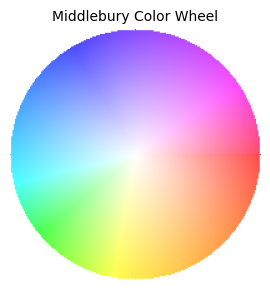

Visualization helpers ready ✅


In [6]:
from ptlflow.utils.flow_utils import flow_to_rgb

def flow_tensor_to_rgb(flow_tensor):
    """
    Convert ptlflow output dict flow tensor to an (H, W, 3) uint8 RGB image.
    flow_tensor shape: (1, 2, H, W)  or  (2, H, W)
    """
    if flow_tensor.dim() == 4:
        flow_tensor = flow_tensor.squeeze(0)          # (2, H, W)
    flow_np = flow_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, 2)
    return flow_to_rgb(flow_np)                       # (H, W, 3) uint8


def flow_tensor_to_numpy(flow_tensor):
    """
    Convert flow tensor (1,2,H,W) or (2,H,W) → numpy (H,W,2) float32.
    """
    if flow_tensor.dim() == 4:
        flow_tensor = flow_tensor.squeeze(0)
    return flow_tensor.permute(1, 2, 0).cpu().numpy()


def draw_color_wheel(size=120):
    """Draw the Middlebury HSV color wheel as a legend."""
    y, x = np.mgrid[-size:size+1, -size:size+1].astype(float)
    r = np.sqrt(x**2 + y**2)
    mask = r <= size
    flow_dummy = np.stack([x, y], axis=-1)
    wheel = flow_to_rgb(flow_dummy)
    wheel[~mask] = 255
    return wheel


def plot_flow_result(img1, img2, flow_tensor, title='FlowNet2 Result', save_path=None):
    """
    4-panel visualization: Frame t | Frame t+1 | Optical Flow | Color Wheel
    img1, img2: (H,W,3) uint8 numpy
    flow_tensor: model output tensor (1,2,H,W)
    """
    flow_vis = flow_tensor_to_rgb(flow_tensor)
    flow_np  = flow_tensor_to_numpy(flow_tensor)
    wheel    = draw_color_wheel(70)

    fig, axes = plt.subplots(1, 4, figsize=(18, 4.5))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    axes[0].imshow(img1);     axes[0].set_title('Frame t',       fontsize=11)
    axes[1].imshow(img2);     axes[1].set_title('Frame t+1',     fontsize=11)
    axes[2].imshow(flow_vis); axes[2].set_title('Optical Flow',  fontsize=11)
    axes[3].imshow(wheel);    axes[3].set_title('Color Wheel\n(hue=dir, sat=speed)', fontsize=10)

    for ax in axes: ax.axis('off')

    u, v = flow_np[:,:,0], flow_np[:,:,1]
    mag  = np.sqrt(u**2 + v**2)
    info = (f'Max: {mag.max():.1f} px  |  Mean: {mag.mean():.2f} px  |  '
            f'u∈[{u.min():.1f}, {u.max():.1f}]  v∈[{v.min():.1f}, {v.max():.1f}]')
    fig.text(0.5, 0.01, info, ha='center', fontsize=9, color='gray')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f'Saved → {save_path}')
    plt.show()


# Preview the color wheel
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(draw_color_wheel(100))
ax.set_title('Middlebury Color Wheel', fontsize=10)
ax.axis('off')
plt.tight_layout()
plt.show()
print('Visualization helpers ready ✅')

## 5. Inference Helper — ptlflow Input Format

ptlflow expects images as a dict: `{'images': tensor}` where the tensor is shaped `(B, T, C, H, W)` — a batch of T-frame sequences. For optical flow, T=2 (a pair of frames).

In [7]:
from ptlflow.utils.io_adapter import IOAdapter

def prepare_input(img1_np, img2_np):
    """
    Convert two (H,W,3) uint8 numpy frames → ptlflow input dict using IOAdapter.
    ptlflow v0.4+ expects BGR images (cv2 convention); IOAdapter handles
    normalisation and tensor formatting internally.
    """
    # ptlflow IOAdapter expects a list of BGR images
    img1_bgr = cv2.cvtColor(img1_np, cv2.COLOR_RGB2BGR)
    img2_bgr = cv2.cvtColor(img2_np, cv2.COLOR_RGB2BGR)

    io_adapter = IOAdapter(model, img1_bgr.shape[:2], cuda=DEVICE.type == 'cuda')
    inputs = io_adapter.prepare_inputs([img1_bgr, img2_bgr])
    return inputs, io_adapter


@torch.no_grad()
def estimate_flow(img1_np, img2_np):
    """
    Run FlowNet2 on a numpy image pair.

    Args:
        img1_np: (H, W, 3) uint8 RGB — frame t
        img2_np: (H, W, 3) uint8 RGB — frame t+1

    Returns:
        flow_tensor: (1, 2, H, W) float32
        flow_np:     (H, W, 2)   float32 numpy
        flow_rgb:    (H, W, 3)   uint8  color visualization
    """
    inputs, _ = prepare_input(img1_np, img2_np)
    preds = model(inputs)

    # ptlflow v0.4 always stores flow under 'flows' with shape (B, 1, 2, H, W)
    flow_tensor = preds['flows'][:, 0]          # → (1, 2, H, W)
    flow_np     = flow_tensor_to_numpy(flow_tensor)
    flow_rgb    = flow_tensor_to_rgb(flow_tensor)

    return flow_tensor, flow_np, flow_rgb


print('Inference helpers ready ✅')

Inference helpers ready ✅


## 6. Synthetic Frame Pairs — Verify the Pipeline

Before testing on real images, we generate synthetic frames with known ground-truth flow to confirm the model and weights are working correctly.

Running FlowNet2 on synthetic test pairs...


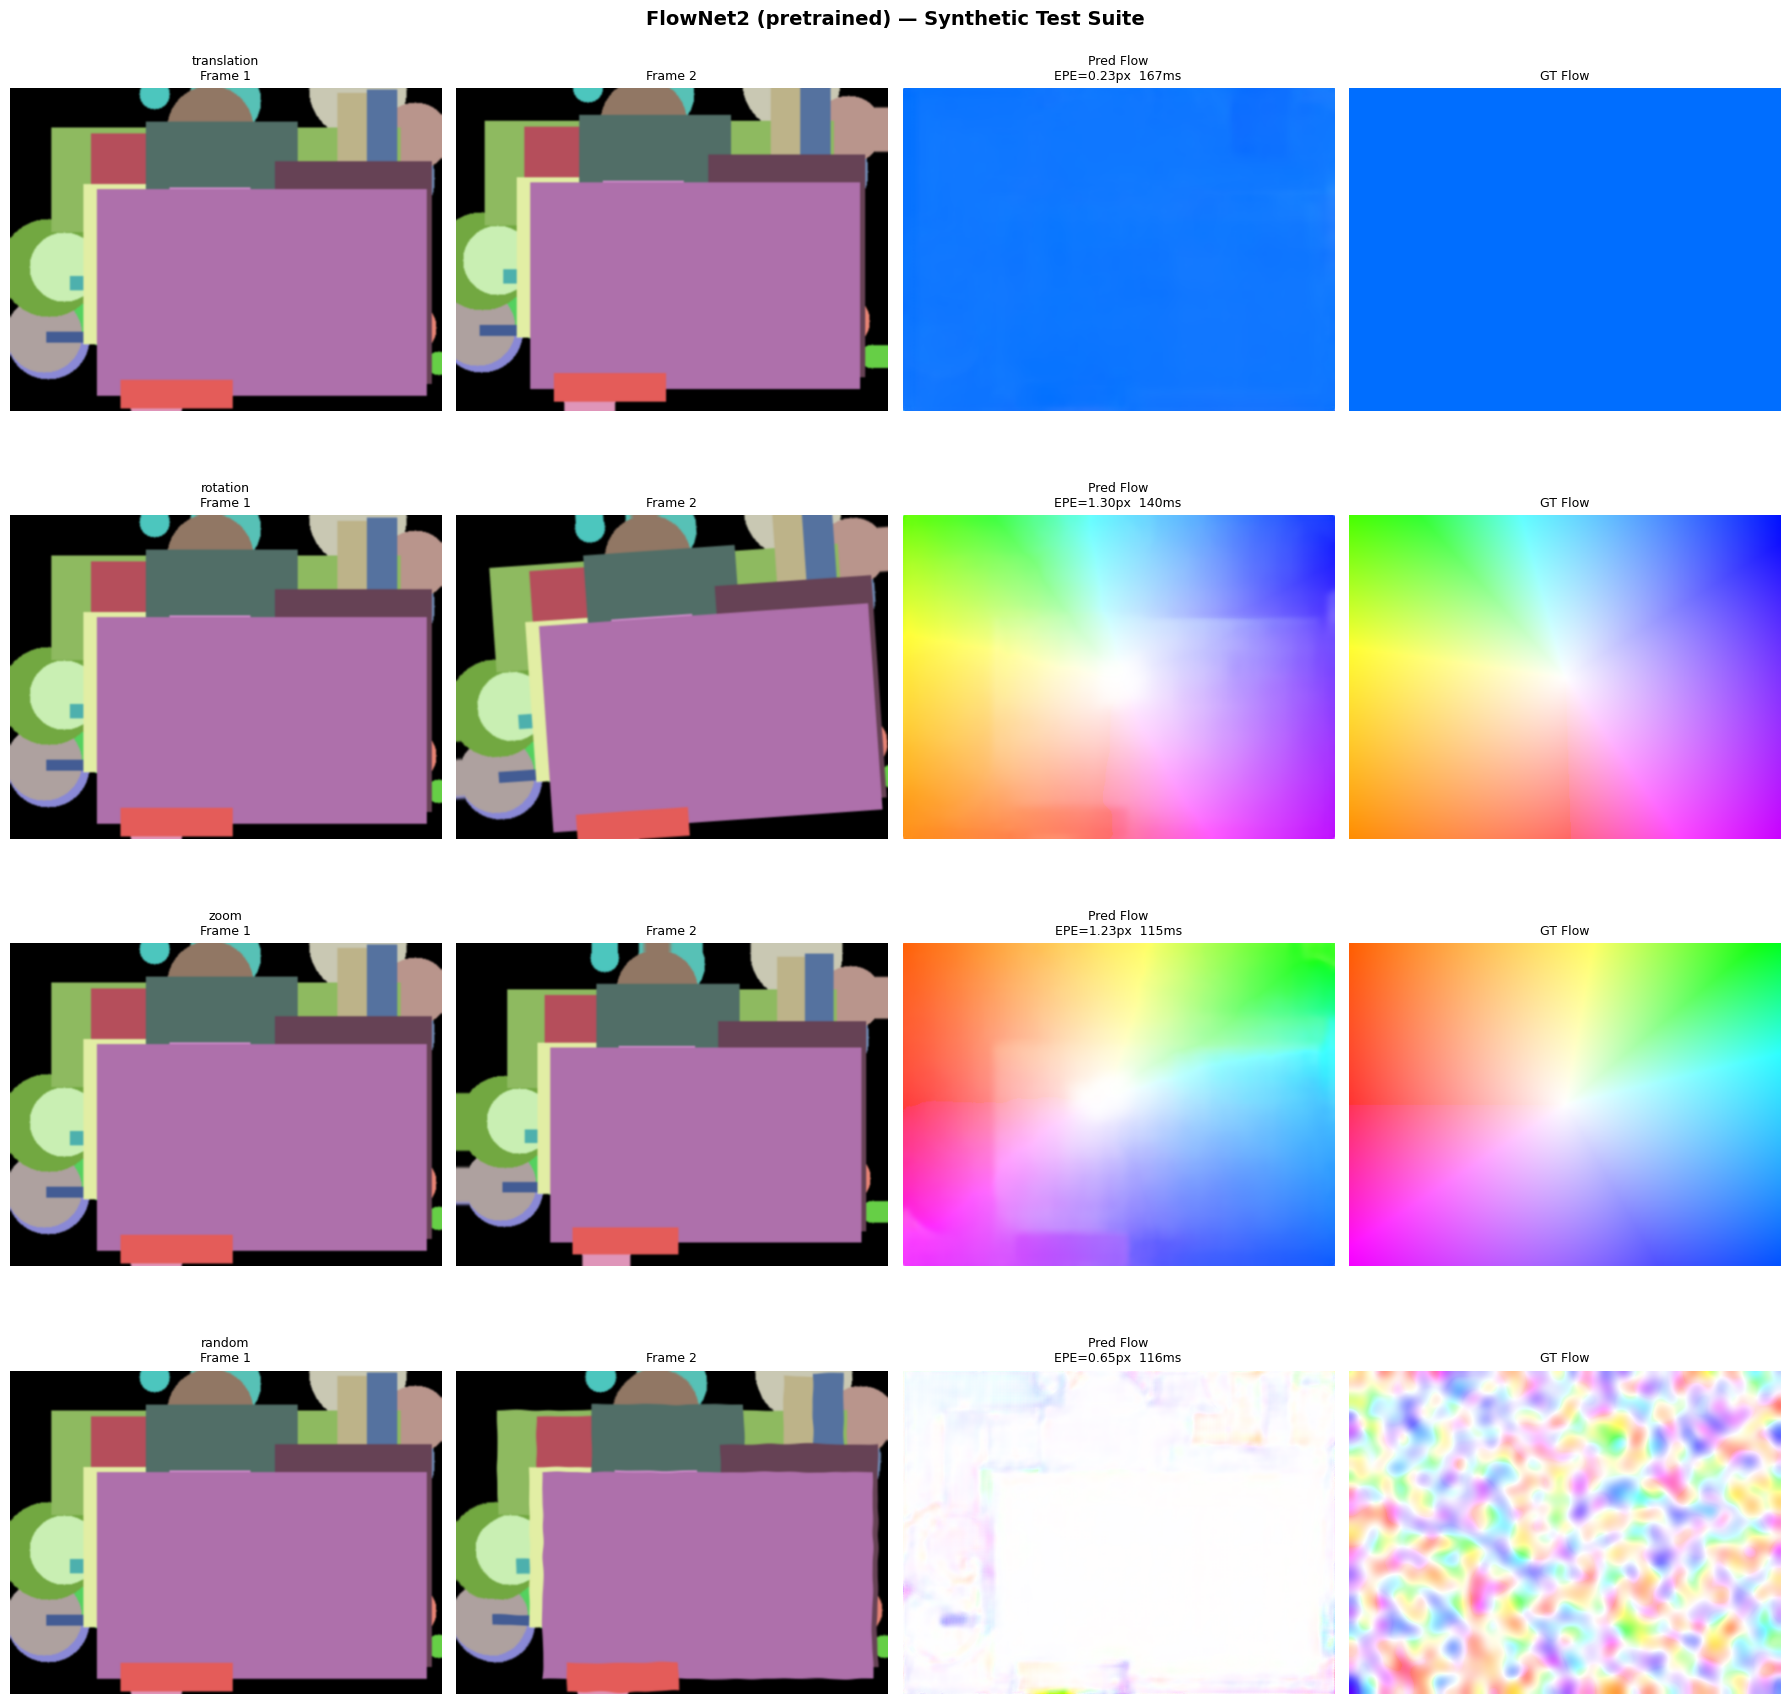


End-Point Error Summary
Motion type        EPE (px)    Time (ms)
------------------------------------------
translation           0.230        167.4
rotation              1.300        139.6
zoom                  1.227        114.9
random                0.650        115.8


In [10]:
def make_synthetic_pair(H=384, W=512, motion_type='translation', seed=42):
    """
    Generate a synthetic image pair with known ground-truth flow.

    motion_type: 'translation' | 'rotation' | 'zoom' | 'random'
    Returns: img1 (H,W,3), img2 (H,W,3), gt_flow (H,W,2) in pixels
    """
    rng = np.random.default_rng(seed)

    # Rich texture base image
    img1 = np.zeros((H, W, 3), dtype=np.uint8)
    for _ in range(35):
        x, y   = rng.integers(0, W), rng.integers(0, H)
        r       = rng.integers(12, 70)
        color   = rng.integers(60, 240, size=3)
        cv2.circle(img1, (x, y), r, color.tolist(), -1)
    for _ in range(20):
        x1, y1 = rng.integers(0, W), rng.integers(0, H)
        x2, y2 = rng.integers(0, W), rng.integers(0, H)
        color   = rng.integers(60, 240, size=3)
        cv2.rectangle(img1, (min(x1,x2), min(y1,y2)), (max(x1,x2), max(y1,y2)), color.tolist(), -1)
    img1 = cv2.GaussianBlur(img1, (5, 5), 0)

    y_g, x_g = np.mgrid[0:H, 0:W].astype(np.float32)

    if motion_type == 'translation':
        dx, dy = 15.0, 8.0
        map_x  = np.clip(x_g + dx, 0, W-1)
        map_y  = np.clip(y_g + dy, 0, H-1)
        gt     = np.stack([np.full((H,W), -dx, dtype=np.float32),
                           np.full((H,W), -dy, dtype=np.float32)], axis=-1)

    elif motion_type == 'rotation':
        angle_r = np.deg2rad(4.0)
        cx, cy  = W/2, H/2
        dx = (x_g - cx) * (np.cos(angle_r) - 1) - (y_g - cy) * np.sin(angle_r)
        dy = (x_g - cx) * np.sin(angle_r)        + (y_g - cy) * (np.cos(angle_r) - 1)
        map_x  = np.clip(x_g + dx, 0, W-1)
        map_y  = np.clip(y_g + dy, 0, H-1)
        gt     = np.stack([-dx, -dy], axis=-1).astype(np.float32)

    elif motion_type == 'zoom':
        scale = 1.06
        cx, cy = W/2, H/2
        dx = (x_g - cx) * (scale - 1)
        dy = (y_g - cy) * (scale - 1)
        map_x  = np.clip(x_g + dx, 0, W-1)
        map_y  = np.clip(y_g + dy, 0, H-1)
        gt     = np.stack([-dx, -dy], axis=-1).astype(np.float32)

    elif motion_type == 'random':
        noise_x = cv2.GaussianBlur(rng.uniform(-25, 25, (H, W)).astype(np.float32), (51,51), 0)
        noise_y = cv2.GaussianBlur(rng.uniform(-25, 25, (H, W)).astype(np.float32), (51,51), 0)
        map_x   = np.clip(x_g + noise_x, 0, W-1)
        map_y   = np.clip(y_g + noise_y, 0, H-1)
        gt      = np.stack([-noise_x, -noise_y], axis=-1)

    else:
        raise ValueError(f'Unknown motion_type: {motion_type}')

    img2 = cv2.remap(img1, map_x.astype(np.float32),
                     map_y.astype(np.float32), cv2.INTER_LINEAR)
    return img1, img2, gt


def endpoint_error(pred_np, gt_np):
    """Mean End-Point Error (EPE) in pixels — standard optical flow metric."""
    diff = pred_np - gt_np
    return float(np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2).mean())


# ── Run on all four motion types ─────────────────────────────────
print('Running FlowNet2 on synthetic test pairs...')

motion_types = ['translation', 'rotation', 'zoom', 'random']
results = {}

fig, axes = plt.subplots(4, 4, figsize=(18, 18))

for row, mtype in enumerate(motion_types):
    i1, i2, gt = make_synthetic_pair(motion_type=mtype)

    t0 = time.perf_counter()
    _, flow_np, flow_rgb = estimate_flow(i1, i2)
    elapsed = (time.perf_counter() - t0) * 1000

    epe = endpoint_error(flow_np, gt)
    results[mtype] = {'epe': epe, 'time_ms': elapsed}

    axes[row,0].imshow(i1);                    axes[row,0].set_title(f'{mtype}\nFrame 1', fontsize=9)
    axes[row,1].imshow(i2);                    axes[row,1].set_title('Frame 2', fontsize=9)
    axes[row,2].imshow(flow_rgb);              axes[row,2].set_title(f'Pred Flow\nEPE={epe:.2f}px  {elapsed:.0f}ms', fontsize=9)
    axes[row,3].imshow(flow_to_rgb(gt));       axes[row,3].set_title('GT Flow', fontsize=9)
    for ax in axes[row]: ax.axis('off')

plt.suptitle('FlowNet2 (pretrained) — Synthetic Test Suite', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/synthetic_results.png', dpi=120, bbox_inches='tight')
plt.show()

print('\nEnd-Point Error Summary')
print(f'{"Motion type":<16} {"EPE (px)":>10} {"Time (ms)":>12}')
print('-' * 42)
for mtype, r in results.items():
    print(f'{mtype:<16} {r["epe"]:>10.3f} {r["time_ms"]:>12.1f}')

## 7. Upload Your Own Images

Upload two consecutive frames from your own video or image sequence.

Upload TWO images (frame1 first, then frame2).
Accepted formats: JPG, PNG, BMP, TIFF


Saving frame10.png to frame10.png
Saving frame11.png to frame11.png

Frame 1: frame10.png  (388, 584, 3)
Frame 2: frame11.png  (388, 584, 3)
Saved → /content/user_flow_result.png


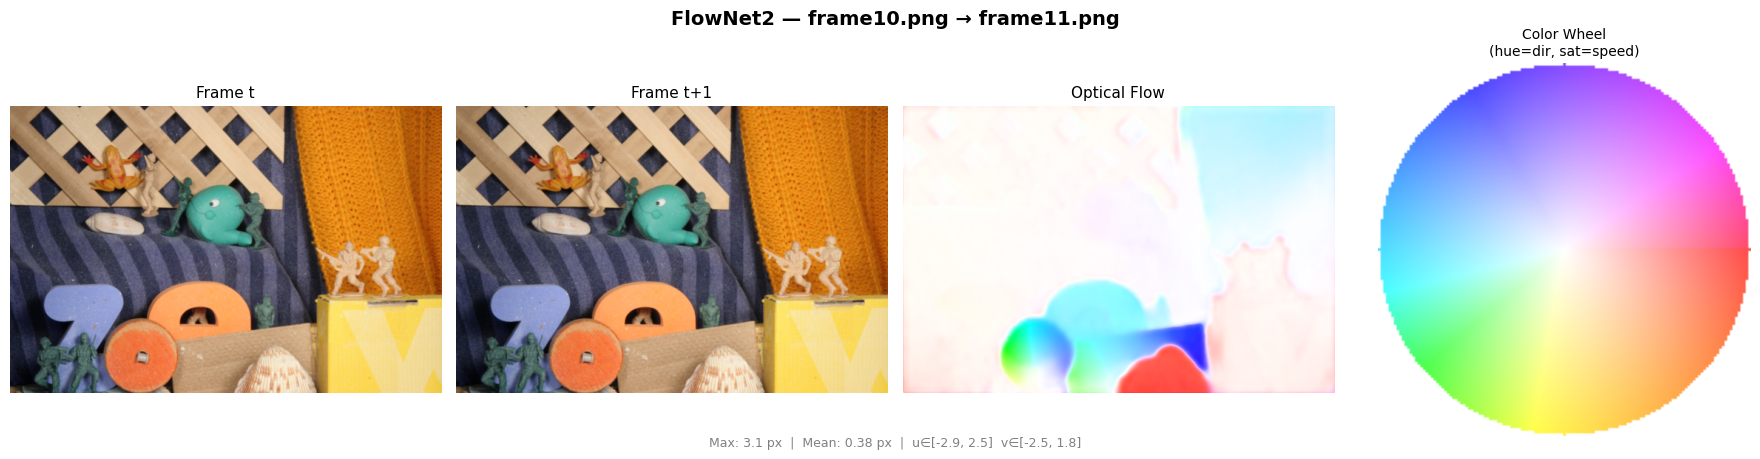

In [11]:
from google.colab import files

print('Upload TWO images (frame1 first, then frame2).')
print('Accepted formats: JPG, PNG, BMP, TIFF')

uploaded = files.upload()

uploaded_paths = sorted(uploaded.keys())

if len(uploaded_paths) >= 2:
    img1_user = np.array(Image.open(uploaded_paths[0]).convert('RGB'))
    img2_user = np.array(Image.open(uploaded_paths[1]).convert('RGB'))

    print(f'\nFrame 1: {uploaded_paths[0]}  {img1_user.shape}')
    print(f'Frame 2: {uploaded_paths[1]}  {img2_user.shape}')

    # Resize frames to the same shape if needed
    if img1_user.shape != img2_user.shape:
        h, w = img1_user.shape[:2]
        img2_user = cv2.resize(img2_user, (w, h))
        print(f'Resized frame 2 to match frame 1: ({h}, {w})')

    _, flow_np_user, flow_rgb_user = estimate_flow(img1_user, img2_user)

    plot_flow_result(img1_user, img2_user,
                     torch.from_numpy(flow_np_user).permute(2,0,1).unsqueeze(0),
                     title=f'FlowNet2 — {uploaded_paths[0]} → {uploaded_paths[1]}',
                     save_path='/content/user_flow_result.png')

elif len(uploaded_paths) == 1:
    print('Only 1 image uploaded — please upload 2 images (a consecutive pair).')
else:
    print('No files uploaded. Upload 2 images to test on your own data.')

## 8. Image Sequence Processing

Process a full sequence by computing flow for every consecutive frame pair.

In [12]:
def process_frame_list(frame_list, output_dir=None, show_progress=True):
    """
    Estimate flow for all consecutive pairs in a list of numpy frames.

    Args:
        frame_list:   list of (H,W,3) uint8 numpy arrays
        output_dir:   if set, saves each flow PNG here
    Returns:
        flows_np:  list of (H,W,2) numpy arrays
        flows_rgb: list of (H,W,3) uint8 visualizations
    """
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    flows_np, flows_rgb = [], []
    pairs = list(zip(frame_list[:-1], frame_list[1:]))
    it = tqdm(enumerate(pairs), total=len(pairs)) if show_progress else enumerate(pairs)

    for idx, (f1, f2) in it:
        _, fnp, frgb = estimate_flow(f1, f2)
        flows_np.append(fnp)
        flows_rgb.append(frgb)

        if output_dir:
            Image.fromarray(frgb).save(os.path.join(output_dir, f'flow_{idx:05d}.png'))

    return flows_np, flows_rgb


def process_video_file(video_path, output_dir=None,
                        output_video_path=None, max_frames=None):
    """
    Read a video file and compute flow for each consecutive frame pair.

    Args:
        video_path:         path to input video
        output_dir:         save flow PNGs here
        output_video_path:  save flow visualization video here
        max_frames:         cap at N frames (for quick demos)
    Returns:
        flows_np: list of (H,W,2) arrays
    """
    import imageio

    cap   = cv2.VideoCapture(video_path)
    fps   = cap.get(cv2.CAP_PROP_FPS)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames:
        total = min(total, max_frames)

    print(f'Reading {total} frames @ {fps:.1f} FPS from: {video_path}')

    frames = []
    for _ in tqdm(range(total), desc='Reading'):
        ret, frame = cap.read()
        if not ret: break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    flows_np, flows_rgb = [], []
    writer = None

    for i in tqdm(range(len(frames) - 1), desc='Computing flow'):
        _, fnp, frgb = estimate_flow(frames[i], frames[i+1])
        flows_np.append(fnp)
        flows_rgb.append(frgb)

        if output_dir:
            Image.fromarray(frgb).save(os.path.join(output_dir, f'flow_{i:05d}.png'))

        if output_video_path:
            if writer is None:
                writer = imageio.get_writer(output_video_path, fps=fps)
            writer.append_data(frgb)

    if writer:
        writer.close()
        print(f'Flow video saved → {output_video_path}')

    return flows_np, flows_rgb


print('Sequence processing functions ready ✅')

Sequence processing functions ready ✅


Synthetic sequence: 8 frames


  0%|          | 0/7 [00:00<?, ?it/s]

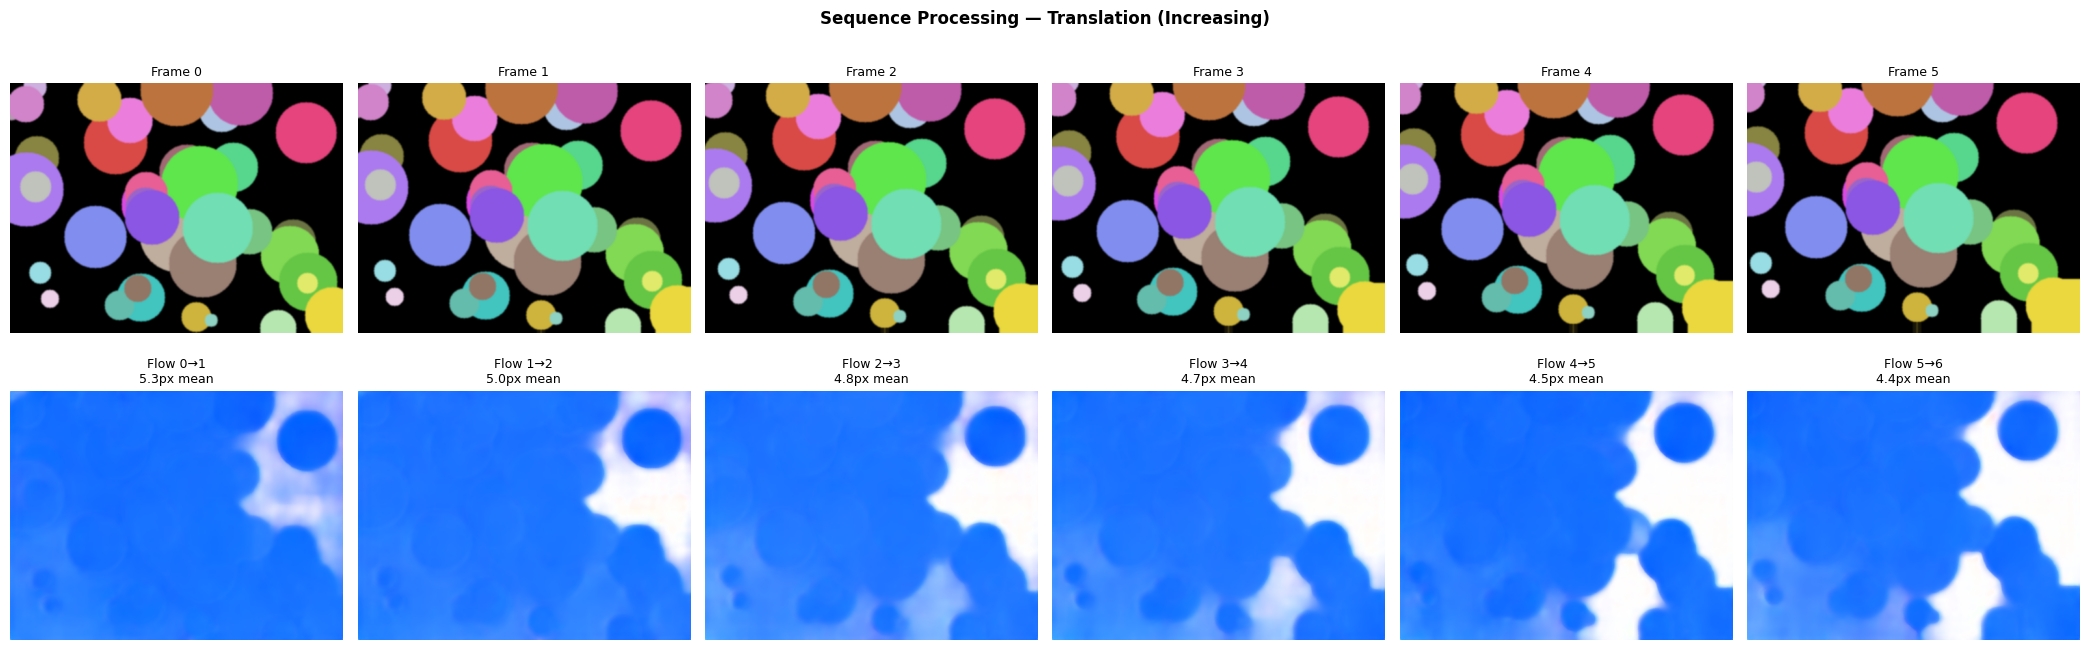


Flow PNGs saved to: /content/seq_flows/


In [13]:
# ── Synthetic sequence demo ───────────────────────────────────────

def make_synthetic_sequence(n_frames=8, H=384, W=512, seed=0):
    """Generate a sequence with smoothly increasing translation."""
    rng = np.random.default_rng(seed)
    base = np.zeros((H, W, 3), dtype=np.uint8)
    for _ in range(40):
        x, y  = rng.integers(0, W), rng.integers(0, H)
        r      = rng.integers(10, 60)
        c      = rng.integers(60, 240, 3)
        cv2.circle(base, (x, y), r, c.tolist(), -1)
    base = cv2.GaussianBlur(base, (5, 5), 0)

    frames = [base]
    y_g, x_g = np.mgrid[0:H, 0:W].astype(np.float32)

    for t in range(1, n_frames):
        dx, dy = float(t * 5), float(t * 3)
        mx = np.clip(x_g + dx, 0, W-1).astype(np.float32)
        my = np.clip(y_g + dy, 0, H-1).astype(np.float32)
        frames.append(cv2.remap(base, mx, my, cv2.INTER_LINEAR))

    return frames


seq = make_synthetic_sequence(n_frames=8)
print(f'Synthetic sequence: {len(seq)} frames')

seq_flows_np, seq_flows_rgb = process_frame_list(seq, output_dir='/content/seq_flows')

# Show results
n_show = min(6, len(seq_flows_rgb))
fig, axes = plt.subplots(2, n_show, figsize=(n_show * 3.5, 7))

for i in range(n_show):
    axes[0,i].imshow(seq[i])
    axes[0,i].set_title(f'Frame {i}', fontsize=9); axes[0,i].axis('off')

    mag = np.sqrt(seq_flows_np[i][:,:,0]**2 + seq_flows_np[i][:,:,1]**2).mean()
    axes[1,i].imshow(seq_flows_rgb[i])
    axes[1,i].set_title(f'Flow {i}→{i+1}\n{mag:.1f}px mean', fontsize=9)
    axes[1,i].axis('off')

plt.suptitle('Sequence Processing — Translation (Increasing)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/sequence_results.png', dpi=120, bbox_inches='tight')
plt.show()

print(f'\nFlow PNGs saved to: /content/seq_flows/')

## 9. Upload and Process Your Own Video

In [ ]:
from google.colab import files

print('Upload a video file (MP4, AVI, MOV).')
print('Tip: A short 2-5 second clip is ideal. Use max_frames to limit processing time.')

uploaded_video = files.upload()

if uploaded_video:
    video_path = list(uploaded_video.keys())[0]
    print(f'\nProcessing: {video_path}')

    video_flows, video_flows_rgb = process_video_file(
        video_path,
        output_dir='/content/video_flows',
        output_video_path='/content/flow_visualization.mp4',
        max_frames=60                         # ← increase for longer videos
    )

    print(f'\nProcessed {len(video_flows)} frame pairs')

    # Show sample frames
    sample_idx = np.linspace(0, len(video_flows_rgb)-1, 5, dtype=int)
    fig, axes  = plt.subplots(1, len(sample_idx), figsize=(18, 4))
    for i, idx in enumerate(sample_idx):
        axes[i].imshow(video_flows_rgb[idx])
        axes[i].set_title(f'Frame pair {idx}', fontsize=9)
        axes[i].axis('off')
    plt.suptitle('Video Flow — Sample Frames', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('No video uploaded. Skipping video processing cell.')

## 10. Flow Analysis & Temporal Statistics

In [ ]:
def analyze_flow_sequence(flows_np, gt_flows=None, title='Flow Sequence Statistics'):
    """
    Plot per-frame statistics: mean magnitude, max magnitude,
    mean direction, and (optionally) EPE vs ground truth.
    """
    mean_mags, max_mags, directions, epes = [], [], [], []

    for i, flow in enumerate(flows_np):
        u, v = flow[:,:,0], flow[:,:,1]
        mag  = np.sqrt(u**2 + v**2)
        mean_mags.append(mag.mean())
        max_mags.append(mag.max())
        directions.append(np.degrees(np.arctan2(v.mean(), u.mean())))
        if gt_flows is not None:
            epes.append(endpoint_error(flow, gt_flows[i]))

    t       = np.arange(len(flows_np))
    n_plots = 4 if gt_flows else 3
    fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 4, 3.5))

    axes[0].plot(t, mean_mags, 'b-o', ms=5, lw=2)
    axes[0].set(title='Mean Magnitude', xlabel='Frame pair', ylabel='pixels')
    axes[0].grid(alpha=0.3)

    axes[1].plot(t, max_mags, 'r-o', ms=5, lw=2)
    axes[1].set(title='Max Magnitude', xlabel='Frame pair', ylabel='pixels')
    axes[1].grid(alpha=0.3)

    axes[2].plot(t, directions, 'g-o', ms=5, lw=2)
    axes[2].set(title='Mean Direction', xlabel='Frame pair', ylabel='degrees')
    axes[2].grid(alpha=0.3)

    if gt_flows:
        axes[3].plot(t, epes, 'm-o', ms=5, lw=2)
        axes[3].set(title=f'EPE  (mean={np.mean(epes):.2f}px)',
                    xlabel='Frame pair', ylabel='pixels')
        axes[3].grid(alpha=0.3)

    plt.suptitle(title, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/flow_statistics.png', dpi=120, bbox_inches='tight')
    plt.show()

    summary = {
        'mean_magnitude_avg': float(np.mean(mean_mags)),
        'peak_magnitude'    : float(np.max(max_mags)),
        'mean_direction_deg': float(np.mean(directions)),
    }
    if gt_flows:
        summary['mean_EPE']   = float(np.mean(epes))
        summary['median_EPE'] = float(np.median(epes))

    return summary


# Run on the synthetic sequence
# Build matching GT flows for the synthetic sequence
H, W = seq[0].shape[:2]
y_g, x_g = np.mgrid[0:H, 0:W].astype(np.float32)
gt_seq = []
for t in range(1, len(seq)):
    dx, dy = float(t * 5), float(t * 3)
    # flow from frame t-1 to frame t
    prev_dx = float((t-1) * 5)
    prev_dy = float((t-1) * 3)
    gt_seq.append(np.stack([np.full((H,W), dx - prev_dx, dtype=np.float32),
                             np.full((H,W), dy - prev_dy, dtype=np.float32)], axis=-1))

stats = analyze_flow_sequence(
    seq_flows_np, gt_flows=gt_seq,
    title='Synthetic Sequence — Temporal Flow Statistics'
)

print('\nSummary Statistics:')
for k, v in stats.items():
    print(f'  {k:<28}: {v:.3f}')

## 11. Downstream Applications

In [ ]:
# ── 11.1  Motion Segmentation ─────────────────────────────────────

def motion_segmentation(flow_np, percentile=75):
    """
    Binary mask of 'moving' pixels using magnitude threshold.
    Morphological cleanup removes noise.
    """
    mag    = np.sqrt(flow_np[:,:,0]**2 + flow_np[:,:,1]**2)
    thresh = np.percentile(mag, percentile)
    mask   = (mag > thresh).astype(np.uint8) * 255
    k      = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask   = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k)
    mask   = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k)
    return mask


# ── 11.2  Frame Interpolation ─────────────────────────────────────

def interpolate_frame(img1_np, img2_np, flow_np, alpha=0.5):
    """
    Generate a virtual frame between img1 and img2 at time alpha ∈ [0,1].
    Uses bidirectional warping + alpha blending.
    """
    H, W = img1_np.shape[:2]
    y_g, x_g = np.mgrid[0:H, 0:W].astype(np.float32)

    # Forward warp: img1 → interpolated position
    mx1 = np.clip(x_g + flow_np[:,:,0] *  alpha,     0, W-1).astype(np.float32)
    my1 = np.clip(y_g + flow_np[:,:,1] *  alpha,     0, H-1).astype(np.float32)

    # Backward warp: img2 → interpolated position
    mx2 = np.clip(x_g + flow_np[:,:,0] * -(1-alpha), 0, W-1).astype(np.float32)
    my2 = np.clip(y_g + flow_np[:,:,1] * -(1-alpha), 0, H-1).astype(np.float32)

    w1 = cv2.remap(img1_np, mx1, my1, cv2.INTER_LINEAR).astype(np.float32)
    w2 = cv2.remap(img2_np, mx2, my2, cv2.INTER_LINEAR).astype(np.float32)

    return np.clip((1 - alpha) * w1 + alpha * w2, 0, 255).astype(np.uint8)


# ── 11.3  Magnitude Heatmap ───────────────────────────────────────

def magnitude_heatmap(flow_np):
    """JET colormap heatmap of flow magnitude."""
    mag  = np.sqrt(flow_np[:,:,0]**2 + flow_np[:,:,1]**2)
    norm = (mag / (mag.max() + 1e-8) * 255).astype(np.uint8)
    return cv2.applyColorMap(norm, cv2.COLORMAP_JET)[:,:,::-1]


# ── 11.4  Sparse Flow Quiver Plot ─────────────────────────────────

def quiver_plot(img_np, flow_np, step=32, scale=1.0, ax=None):
    """
    Overlay sparse flow arrows on the image.
    step: grid spacing between arrows (pixels)
    """
    H, W = flow_np.shape[:2]
    y_pts = np.arange(step//2, H, step)
    x_pts = np.arange(step//2, W, step)
    X, Y  = np.meshgrid(x_pts, y_pts)
    U     = flow_np[Y, X, 0] * scale
    V     = flow_np[Y, X, 1] * scale

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    ax.imshow(img_np)
    ax.quiver(X, Y, U, -V, color='yellow', scale=1, scale_units='xy',
              angles='xy', width=0.003, headwidth=4, alpha=0.85)
    return ax


# ── Demo all four applications ────────────────────────────────────
demo1, demo2, demo_gt = make_synthetic_pair(motion_type='random')
_, demo_flow_np, demo_flow_rgb = estimate_flow(demo1, demo2)

mask    = motion_segmentation(demo_flow_np, percentile=70)
interp  = interpolate_frame(demo1, demo2, demo_flow_np, alpha=0.5)
heatmap = magnitude_heatmap(demo_flow_np)

# Overlay: highlight moving pixels in red
overlay = demo1.copy().astype(np.float32)
overlay[mask > 0] = overlay[mask > 0] * 0.3 + np.array([255, 60, 60]) * 0.7
overlay = np.clip(overlay, 0, 255).astype(np.uint8)

fig = plt.figure(figsize=(18, 12))
ax_titles = [
    ('Frame t',               demo1),
    ('Frame t+1',             demo2),
    ('Optical Flow (color)',  demo_flow_rgb),
    ('Magnitude Heatmap',     heatmap),
    ('Motion Mask',           mask),
    ('Motion Overlay',        overlay),
    ('Interpolated t=0.5',    interp),
]

for i, (title, img) in enumerate(ax_titles):
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    ax.set_title(title, fontsize=10, fontweight='bold'); ax.axis('off')

# Quiver plot in last panel
ax8 = fig.add_subplot(2, 4, 8)
quiver_plot(demo1, demo_flow_np, step=30, scale=0.5, ax=ax8)
ax8.set_title('Sparse Flow Vectors', fontsize=10, fontweight='bold'); ax8.axis('off')

plt.suptitle('FlowNet2 — Downstream Applications', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/applications.png', dpi=130, bbox_inches='tight')
plt.show()

## 12. Comparison: FlowNet2 vs Classical Baselines

In [ ]:
from scipy.interpolate import griddata

def farneback_flow(img1_np, img2_np):
    """Dense Gunnar Farneback optical flow."""
    g1 = cv2.cvtColor(img1_np, cv2.COLOR_RGB2GRAY)
    g2 = cv2.cvtColor(img2_np, cv2.COLOR_RGB2GRAY)
    return cv2.calcOpticalFlowFarneback(
        g1, g2, None, pyr_scale=0.5, levels=5,
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )


def lucas_kanade_flow(img1_np, img2_np):
    """Sparse Lucas-Kanade flow interpolated to dense."""
    g1 = cv2.cvtColor(img1_np, cv2.COLOR_RGB2GRAY)
    g2 = cv2.cvtColor(img2_np, cv2.COLOR_RGB2GRAY)
    pts = cv2.goodFeaturesToTrack(g1, maxCorners=800, qualityLevel=0.01,
                                   minDistance=8, blockSize=7)
    H, W = img1_np.shape[:2]
    if pts is None:
        return np.zeros((H, W, 2), dtype=np.float32)

    lk_params = dict(winSize=(21,21), maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    pts2, st, _ = cv2.calcOpticalFlowPyrLK(g1, g2, pts, None, **lk_params)
    good_old = pts[st == 1].reshape(-1, 2)
    good_new = pts2[st == 1].reshape(-1, 2)
    vecs = good_new - good_old

    gy, gx = np.mgrid[0:H, 0:W]
    dense = np.zeros((H, W, 2), dtype=np.float32)
    for c in range(2):
        dense[:,:,c] = griddata(good_old, vecs[:,c],
                                 (gx, gy), method='linear', fill_value=0)
    return dense


# Benchmark
bench_img1, bench_img2, bench_gt = make_synthetic_pair(motion_type='random', seed=7)

methods = {}
for name, fn in [('FlowNet2', lambda: estimate_flow(bench_img1, bench_img2)[1]),
                  ('Farneback', lambda: farneback_flow(bench_img1, bench_img2)),
                  ('Lucas-Kanade', lambda: lucas_kanade_flow(bench_img1, bench_img2))]:
    t0 = time.perf_counter()
    flow = fn()
    elapsed = (time.perf_counter() - t0) * 1000
    epe = endpoint_error(flow, bench_gt)
    methods[name] = {'flow': flow, 'epe': epe, 'time_ms': elapsed}


# Visualize
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
names = list(methods.keys()) + ['Ground Truth']
flows_vis = [flow_to_rgb(methods[n]['flow']) for n in list(methods.keys())] + [flow_to_rgb(bench_gt)]

for i, (name, vis) in enumerate(zip(names, flows_vis)):
    epe = methods[name]['epe'] if name != 'Ground Truth' else 0.0
    t   = methods[name]['time_ms'] if name != 'Ground Truth' else 0.0
    label = f'EPE={epe:.2f}px  {t:.0f}ms' if name != 'Ground Truth' else 'Reference'
    axes[0,i].imshow(vis)
    axes[0,i].set_title(f'{name}\n{label}', fontsize=10, fontweight='bold')
    axes[0,i].axis('off')

    err = flow_to_rgb(methods[name]['flow'] - bench_gt) if name != 'Ground Truth' else vis
    axes[1,i].imshow(err)
    axes[1,i].set_title('Error map' if name != 'Ground Truth' else 'GT flow', fontsize=10)
    axes[1,i].axis('off')

plt.suptitle('Benchmark: FlowNet2 vs Classical Methods', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/benchmark_comparison.png', dpi=130, bbox_inches='tight')
plt.show()

print(f'\n{"Method":<16} {"EPE (px)":>10} {"Time (ms)":>12}')
print('-' * 42)
for name, r in methods.items():
    print(f'{name:<16} {r["epe"]:>10.3f} {r["time_ms"]:>12.1f}')

## 13. (Optional) Mount Google Drive

For processing large datasets or saving results permanently.

In [ ]:
# Uncomment to mount Google Drive

# from google.colab import drive
# drive.mount('/content/drive')
#
# DRIVE_DIR  = '/content/drive/MyDrive/flownet2_outputs'
# os.makedirs(DRIVE_DIR, exist_ok=True)
#
# # Example: process frames from Drive and save back to Drive
# FRAMES_DIR = '/content/drive/MyDrive/my_video_frames'
#
# if os.path.isdir(FRAMES_DIR):
#     exts   = {'.jpg', '.jpeg', '.png', '.bmp'}
#     paths  = sorted([str(p) for p in Path(FRAMES_DIR).iterdir()
#                      if p.suffix.lower() in exts])
#     frames = [np.array(Image.open(p).convert('RGB')) for p in paths]
#     print(f'Loaded {len(frames)} frames from Drive')
#
#     drive_flows, drive_rgbs = process_frame_list(
#         frames, output_dir=os.path.join(DRIVE_DIR, 'flow_pngs')
#     )
#     stats = analyze_flow_sequence(drive_flows)
#     print(f'Done. Results saved to {DRIVE_DIR}')

print('Drive mounting cell (skipped — uncomment to use).')

## 14. Download All Results

Download every output file generated by this notebook.

In [ ]:
from google.colab import files
import zipfile

output_files = [
    '/content/synthetic_results.png',
    '/content/sequence_results.png',
    '/content/flow_statistics.png',
    '/content/applications.png',
    '/content/benchmark_comparison.png',
]

# Add any video output
if os.path.exists('/content/flow_visualization.mp4'):
    output_files.append('/content/flow_visualization.mp4')

if os.path.exists('/content/user_flow_result.png'):
    output_files.append('/content/user_flow_result.png')

# Zip everything
zip_path = '/content/flownet2_results.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for f in output_files:
        if os.path.exists(f):
            zf.write(f, os.path.basename(f))
            print(f'  Added: {os.path.basename(f)}')
        else:
            print(f'  Skipped (not found): {f}')

print(f'\nDownloading: flownet2_results.zip')
files.download(zip_path)

## Summary

| Component | Role |
|---|---|
| `ptlflow.get_model('flownet2', pretrained_ckpt=...)` | Load FlowNet2 + auto-download weights |
| `prepare_input(img1, img2)` | Format numpy frames → ptlflow dict format |
| `estimate_flow(img1, img2)` | Single-pair inference → flow tensor + numpy + RGB |
| `process_frame_list(frames)` | Full sequence → list of flow arrays |
| `process_video_file(path)` | Video file → flow sequence + optional output video |
| `analyze_flow_sequence(flows)` | Temporal statistics + EPE if GT available |
| `motion_segmentation(flow)` | Moving pixel mask via magnitude threshold |
| `interpolate_frame(...)` | Virtual in-between frame via bidirectional warp |
| `magnitude_heatmap(flow)` | JET colormap speed map |

### Available Checkpoints via ptlflow
```python
ptlflow.get_model('flownet2',  pretrained_ckpt='things')   # General purpose
ptlflow.get_model('flownetc',  pretrained_ckpt='things')   # Correlation sub-net only
ptlflow.get_model('flownets',  pretrained_ckpt='things')   # Simple sub-net only
ptlflow.get_model('flownetcs', pretrained_ckpt='things')   # C+S stacked
```

### References
- FlowNet2 paper: Ilg et al., *FlowNet 2.0*, CVPR 2017 — https://arxiv.org/abs/1612.01925
- ptlflow library: https://github.com/hmorimitsu/ptlflow
- NVIDIA FlowNet2-PyTorch: https://github.com/NVIDIA/flownet2-pytorch